### Base

In [8]:
import pandas as pd

In [26]:
df = pd.read_csv("/home/ensai/imatag/website_categorization_custom/categorization/Datasets/URL Classification.csv")


In [30]:
len(df)

1562977

In [29]:
df['Adult'].value_counts()

Arts          253840
Society       243943
Business      240177
Computers     117962
Science       110286
Recreation    106586
Sports        101328
Shopping       95270
Health         60097
Reference      58247
Games          56477
Kids           46182
Adult          35324
Home           28269
News            8989
Name: Adult, dtype: int64

In [22]:
df[''].values_counts()

AttributeError: 'DataFrame' object has no attribute 'values_counts'

In [21]:
len(df)

1562977

In [18]:
df['tokens'][10]

"['ad', 'domination', 'awesome', 'strategy', 'authentic', 'storyline', 'addictive', 'pvp', 'battle', 'manual', 'forum', 'statistic', 'play', 'english', 'espa', 'ol', 'italiano', 'deutsch', 'fran', 'ai', 'portugu', 'polski', 'tina', 'nederland', 'rom', 'lietuvi', 'latvie', 'magyar', 'dansk', 'bahasa', 'indonesia', 'ti', 'ng', 'vi', 'eesti', 'log', 'login', 'username', 'password', 'forgot', 'password', 'play', 'register', 'tutorial', 'initial', 'city', 'development', 'developing', 'city', 'developing', 'army', 'commander', 'army', 'controlling', 'army', 'trading', 'valuable', 'resource', 'adventure', 'exploring', 'location', 'interact', 'player', 'screenshots', 'strategy', 'game', 'strategy', 'strategy', 'game', 'war', 'game', 'browser', 'game', 'war', 'strategy', 'war', 'game', 'battle', 'game', 'battle', 'attack', 'game', 'combat', 'game', 'defense', 'game', 'internet', 'game', 'medieval', 'game', 'military', 'game', 'mmo', 'game', 'mmorpg', 'game', 'multiplayer', 'game', 'web', 'game'

In [5]:
df.main_category.value_counts()

Food_and_Drink              1242
Health                      1224
Beauty_and_Fitness          1062
Law_and_Government          1058
Books_and_Literature        1003
Reference                    966
Sports                       863
Autos_and_Vehicles           854
Gambling                     741
People_and_Society           675
Finance                      634
Internet_and_Telecom         571
Computer_and_Electronics     570
Science                      533
Business_and_Industry        532
News_and_Media               455
Career_and_Education         453
Travel                       396
Games                        354
Shopping                     347
Arts_and_Entertainment       335
Recreation_and_Hobbies       239
Pets_and_Animals             221
Adult                        119
Home_and_Garden               89
Name: main_category, dtype: int64

In [6]:
import ast

def convert_to_list(row):
    return ast.literal_eval(row['tokens'])

In [7]:
df['tokens'] = df.apply(convert_to_list, axis = 1)

KeyboardInterrupt: 

In [ ]:
df = df[df['tokens'].map(len) > 1]

In [ ]:
df.head()

,url,main_category,main_category_confidence,tld,tokens
0,http://000webhost.com,Internet_and_Telecom,0.5581,com,"[web, hosting, host, website, cpanel, php, sal..."
2,http://0calc.com,Science,0.5606,com,"[web, scientific, calculator, register, login,..."
5,http://100diet.net,Health,0.5991,net,"[diet, diet, javascript, diet]"
7,http://1091.co.jp,Sports,0.5912,jp,"[co, iupdate, tweet, www, co, qr, qr, url, cop..."
8,http://10bet.com,Gambling,0.7795,com,"[bet, bet, sport, betting, welcome, bonus, ope..."


### Custom

In [ ]:
X = pd.DataFrame(df, columns=['tokens'])
Y = pd.DataFrame(df, columns=['main_category'])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [ ]:
import nltk

In [ ]:
words_frequency = {}
for category in y_train.main_category.unique():
    print(category)
    all_words = []
    df_temp = X_train[y_train.main_category == category]
    for word in df_temp.tokens:
        all_words.extend(word)
    most_common = [word[0] for word in nltk.FreqDist(all_words).most_common(20000)]
    words_frequency[category] = most_common

Health
Business_and_Industry
Adult
Books_and_Literature
Shopping
People_and_Society
Food_and_Drink
Pets_and_Animals
Finance
Gambling
Science
Beauty_and_Fitness
Reference
Sports
News_and_Media
Career_and_Education
Arts_and_Entertainment
Law_and_Government
Autos_and_Vehicles
Games
Computer_and_Electronics
Recreation_and_Hobbies
Internet_and_Telecom
Travel
Home_and_Garden


In [ ]:
def predict_category(tokens, words_frequency = words_frequency):
    category_weights = []
    for category in words_frequency:
        weight = 0
        intersect_words = set(words_frequency[category]).intersection(set(tokens))
        for word in intersect_words:
            if word in tokens:
                index = words_frequency[category].index(word)
                weight += 20000 - index
        category_weights.append(weight)

    category_index = category_weights.index(max(category_weights))
    main_category = list(words_frequency.keys())[category_index]
    category_weight = max(category_weights)
    category_weights[category_index] = 0
    category_index = category_weights.index(max(category_weights))
    main_category_2 = list(words_frequency.keys())[category_index]
    category_weight_2 = max(category_weights)
    return main_category


In [ ]:
y_pred = []

In [ ]:
import concurrent.futures

In [ ]:
X_test

,tokens
9218,"[law, firm, success, withersworldwide, newsroo..."
11024,"[neverthirsty, bible, study, bible, spiritual,..."
10427,"[buy, chocolate, gift, hamper, australia, choc..."
502,"[accueil, hotel, paris, collection, tels, tels..."
5043,"[fusce, sem, sapien, tristique, ligula, justo,..."
...,...
14581,"[bain, capital, investor, login, location, bai..."
2276,"[landr, creative, tool, musiciansthis, app, wo..."
681,"[buccaneer, tampa, bay, buccaneer, skip, main,..."
11000,"[english, french, urdu, pashto, swahili, hausa..."


In [ ]:
with concurrent.futures.ThreadPoolExecutor(32) as executor:
    futures = []
    for index,row in X_test.iterrows():
        futures.append(executor.submit(predict_category, tokens=row['tokens']))

In [ ]:
len(X_test)

2985

In [ ]:
for future in futures:
    y_pred.append(future.result())

In [ ]:
len(y_pred)

2985

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
accuracy

0.5333333333333333

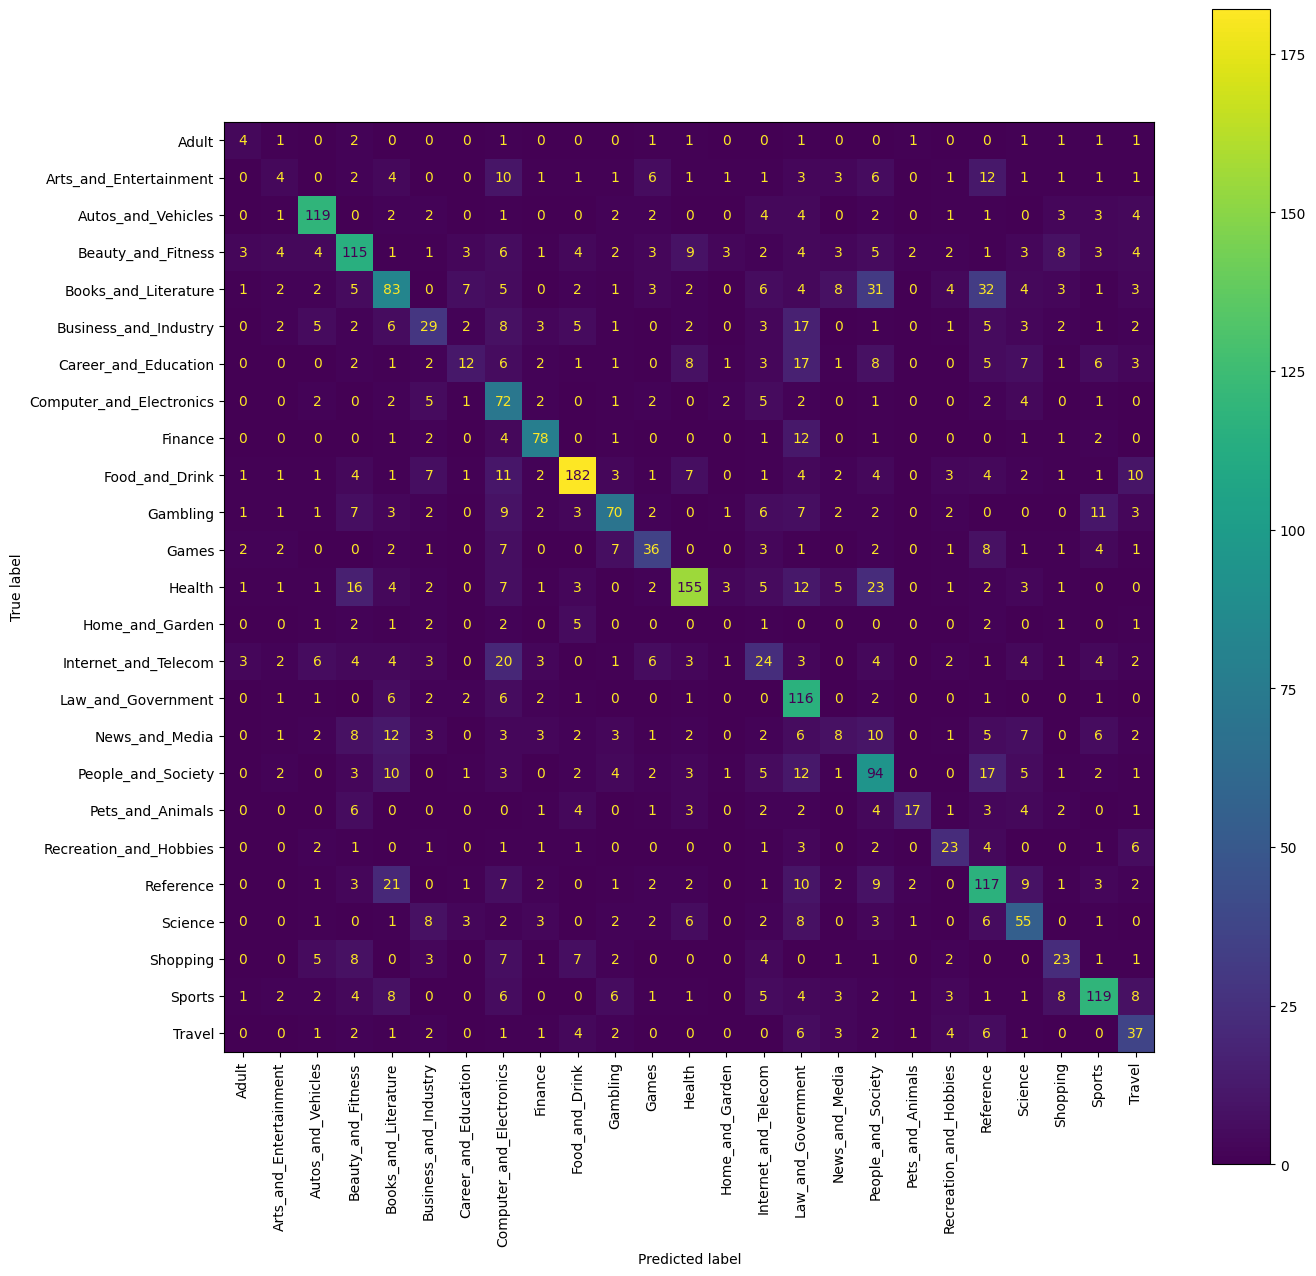

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred,xticks_rotation='vertical')

fig = cm_display.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

plt.show() 

In [ ]:
data_tokens = [' '.join(row['tokens']) for index,row in X.iterrows()]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=20000, max_df=0.8)
X_custom = matrix.fit_transform(data_tokens)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_custom_tfidf = tfidf_transformer.fit_transform(X_custom)

In [ ]:
X_custom_tfidf

<11938x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 2343433 stored elements in Compressed Sparse Row format>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_custom, Y, random_state=42, stratify=Y)

In [ ]:
#y = [data[i]['class'] for i in range(len(data))]

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import balanced_accuracy_score, f1_score
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train, sample_weight=)

#Predict Class
y_pred_custom = classifier.predict(X_test)

#Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_custom)

/home/ensai/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.metrics import balanced_accuracy_score, f1_score

In [ ]:
f1_score(y_test,y_pred_custom,average='weighted')

0.5902967699211026

In [ ]:
accuracy

0.5882747068676717

In [ ]:
y_predict_two = classifier.predict_proba(X_test)

In [ ]:
y_predict_two[0]

array([0.0008378 , 0.0146801 , 0.06942851, 0.03894832, 0.04100465,
       0.060191  , 0.07657008, 0.02286212, 0.05253067, 0.0564721 ,
       0.01829096, 0.01025562, 0.08387688, 0.00337729, 0.0112566 ,
       0.07304477, 0.03338593, 0.06840901, 0.01051468, 0.01446609,
       0.07418542, 0.07223994, 0.01346766, 0.04033434, 0.03936945])

In [ ]:
import numpy as np

In [ ]:
ind = np.argpartition(y_predict_two[0], -2)[-2:]

In [ ]:
ind

array([ 6, 12])

In [ ]:
ind[np.argsort(y_predict_two[0][ind])]

array([ 6, 12])

In [ ]:
liste_i = [np.argpartition(y_predict_two[k], -2)[-2:][np.argsort(y_predict_two[k][np.argpartition(y_predict_two[k], -2)[-2:]])][0] for k in range(len(y_predict_two))]

In [ ]:
liste_i

[6,
 24,
 5,
 14,
 12,
 1,
 10,
 16,
 16,
 11,
 24,
 21,
 21,
 22,
 22,
 14,
 16,
 18,
 16,
 24,
 5,
 22,
 8,
 11,
 8,
 16,
 16,
 24,
 3,
 23,
 19,
 5,
 17,
 7,
 12,
 5,
 6,
 3,
 3,
 1,
 8,
 17,
 1,
 17,
 8,
 6,
 3,
 17,
 6,
 19,
 3,
 5,
 2,
 21,
 6,
 17,
 6,
 12,
 17,
 8,
 3,
 21,
 16,
 24,
 19,
 21,
 7,
 7,
 12,
 16,
 14,
 14,
 17,
 20,
 22,
 7,
 16,
 21,
 16,
 12,
 21,
 20,
 16,
 16,
 21,
 5,
 22,
 17,
 11,
 8,
 19,
 6,
 14,
 20,
 8,
 8,
 5,
 16,
 12,
 8,
 5,
 1,
 23,
 19,
 22,
 7,
 15,
 5,
 17,
 22,
 1,
 6,
 23,
 19,
 7,
 21,
 15,
 8,
 17,
 19,
 15,
 14,
 24,
 5,
 17,
 11,
 5,
 6,
 6,
 6,
 3,
 5,
 6,
 5,
 8,
 21,
 6,
 7,
 23,
 16,
 15,
 8,
 4,
 8,
 2,
 20,
 8,
 16,
 8,
 13,
 12,
 2,
 24,
 17,
 12,
 17,
 16,
 15,
 5,
 22,
 15,
 8,
 20,
 3,
 3,
 23,
 3,
 24,
 4,
 5,
 24,
 5,
 10,
 14,
 15,
 11,
 12,
 17,
 24,
 9,
 14,
 9,
 17,
 22,
 22,
 8,
 16,
 5,
 12,
 5,
 3,
 21,
 12,
 6,
 19,
 19,
 6,
 24,
 23,
 23,
 13,
 17,
 21,
 19,
 1,
 16,
 7,
 2,
 10,
 15,
 12,
 5,
 17,
 13,
 13,
 1,
 0,
 

In [ ]:
y_second_prob = [classifier.classes_[i] for i in liste_i]

In [ ]:
y_second_prob

['Career_and_Education',
 'Travel',
 'Business_and_Industry',
 'Internet_and_Telecom',
 'Health',
 'Arts_and_Entertainment',
 'Gambling',
 'News_and_Media',
 'News_and_Media',
 'Games',
 'Travel',
 'Science',
 'Science',
 'Shopping',
 'Shopping',
 'Internet_and_Telecom',
 'News_and_Media',
 'Pets_and_Animals',
 'News_and_Media',
 'Travel',
 'Business_and_Industry',
 'Shopping',
 'Finance',
 'Games',
 'Finance',
 'News_and_Media',
 'News_and_Media',
 'Travel',
 'Beauty_and_Fitness',
 'Sports',
 'Recreation_and_Hobbies',
 'Business_and_Industry',
 'People_and_Society',
 'Computer_and_Electronics',
 'Health',
 'Business_and_Industry',
 'Career_and_Education',
 'Beauty_and_Fitness',
 'Beauty_and_Fitness',
 'Arts_and_Entertainment',
 'Finance',
 'People_and_Society',
 'Arts_and_Entertainment',
 'People_and_Society',
 'Finance',
 'Career_and_Education',
 'Beauty_and_Fitness',
 'People_and_Society',
 'Career_and_Education',
 'Recreation_and_Hobbies',
 'Beauty_and_Fitness',
 'Business_and_Indu

In [ ]:
diff = pd.DataFrame(list(zip(y_pred_custom,y_second_prob, y_test['main_category'])), columns = ['Primary', 'Secondary', 'true'])

In [ ]:
diff

,Primary,Secondary,true
0,Health,Career_and_Education,Health
1,Business_and_Industry,Travel,Business_and_Industry
2,Computer_and_Electronics,Business_and_Industry,Reference
3,Computer_and_Electronics,Internet_and_Telecom,Computer_and_Electronics
4,Science,Health,Science
...,...,...,...
2980,Business_and_Industry,Computer_and_Electronics,Computer_and_Electronics
2981,Beauty_and_Fitness,Career_and_Education,Beauty_and_Fitness
2982,Reference,Law_and_Government,Reference
2983,Science,Pets_and_Animals,Adult


In [ ]:
y_test.value_counts()

main_category           
Food_and_Drink              253
Health                      239
Books_and_Literature        203
Reference                   200
Beauty_and_Fitness          198
Sports                      178
Law_and_Government          169
Autos_and_Vehicles          153
People_and_Society          145
Gambling                    128
Finance                     118
Computer_and_Electronics    112
Science                     110
Internet_and_Telecom        104
Business_and_Industry        99
News_and_Media               88
Career_and_Education         82
Travel                       78
Games                        72
Shopping                     64
Arts_and_Entertainment       60
Recreation_and_Hobbies       51
Pets_and_Animals             46
Adult                        19
Home_and_Garden              16
dtype: int64

In [ ]:
np.mean(y_pred_custom == 'Food_and_Drink')

0.0864321608040201

In [ ]:
only_diff = diff[diff['Primary'] != diff['true']]

In [ ]:
only_diff = only_diff[['Secondary', 'true']]

In [ ]:
only_diff.to_csv('export/only_diff_nb.csv')

In [ ]:
np.sum(only_diff['Secondary'] == only_diff['true'])/len(only_diff)

0.27339300244100895

In [ ]:
diff[0]

main_category
Health                                        Health
Business_and_Industry          Business_and_Industry
Reference                   Computer_and_Electronics
Computer_and_Electronics    Computer_and_Electronics
Science                                      Science
                                      ...           
Computer_and_Electronics       Business_and_Industry
Beauty_and_Fitness                Beauty_and_Fitness
Reference                                  Reference
Adult                                        Science
Recreation_and_Hobbies                        Sports
Name: 0, Length: 2985, dtype: object

In [ ]:
sum_temp = 0
for i in range(len(y_pred_custom)):
    if y_pred_custom[i] == y_test.iloc[i]['main_category']:
        sum_temp += 1
    elif y_second_prob[i] == y_test.iloc[i]['main_category']:
        sum_temp += 1

In [ ]:
sum_temp/len(y_pred_custom)

0.7008375209380234

In [ ]:
y_pred_custom

array(['Health', 'Business_and_Industry', 'Computer_and_Electronics', ...,
       'Reference', 'Science', 'Sports'], dtype='<U24')

In [ ]:
classifier.classes_

array(['Adult', 'Arts_and_Entertainment', 'Autos_and_Vehicles',
       'Beauty_and_Fitness', 'Books_and_Literature',
       'Business_and_Industry', 'Career_and_Education',
       'Computer_and_Electronics', 'Finance', 'Food_and_Drink',
       'Gambling', 'Games', 'Health', 'Home_and_Garden',
       'Internet_and_Telecom', 'Law_and_Government', 'News_and_Media',
       'People_and_Society', 'Pets_and_Animals', 'Recreation_and_Hobbies',
       'Reference', 'Science', 'Shopping', 'Sports', 'Travel'],
      dtype='<U24')

In [ ]:
len(X_test)

2985

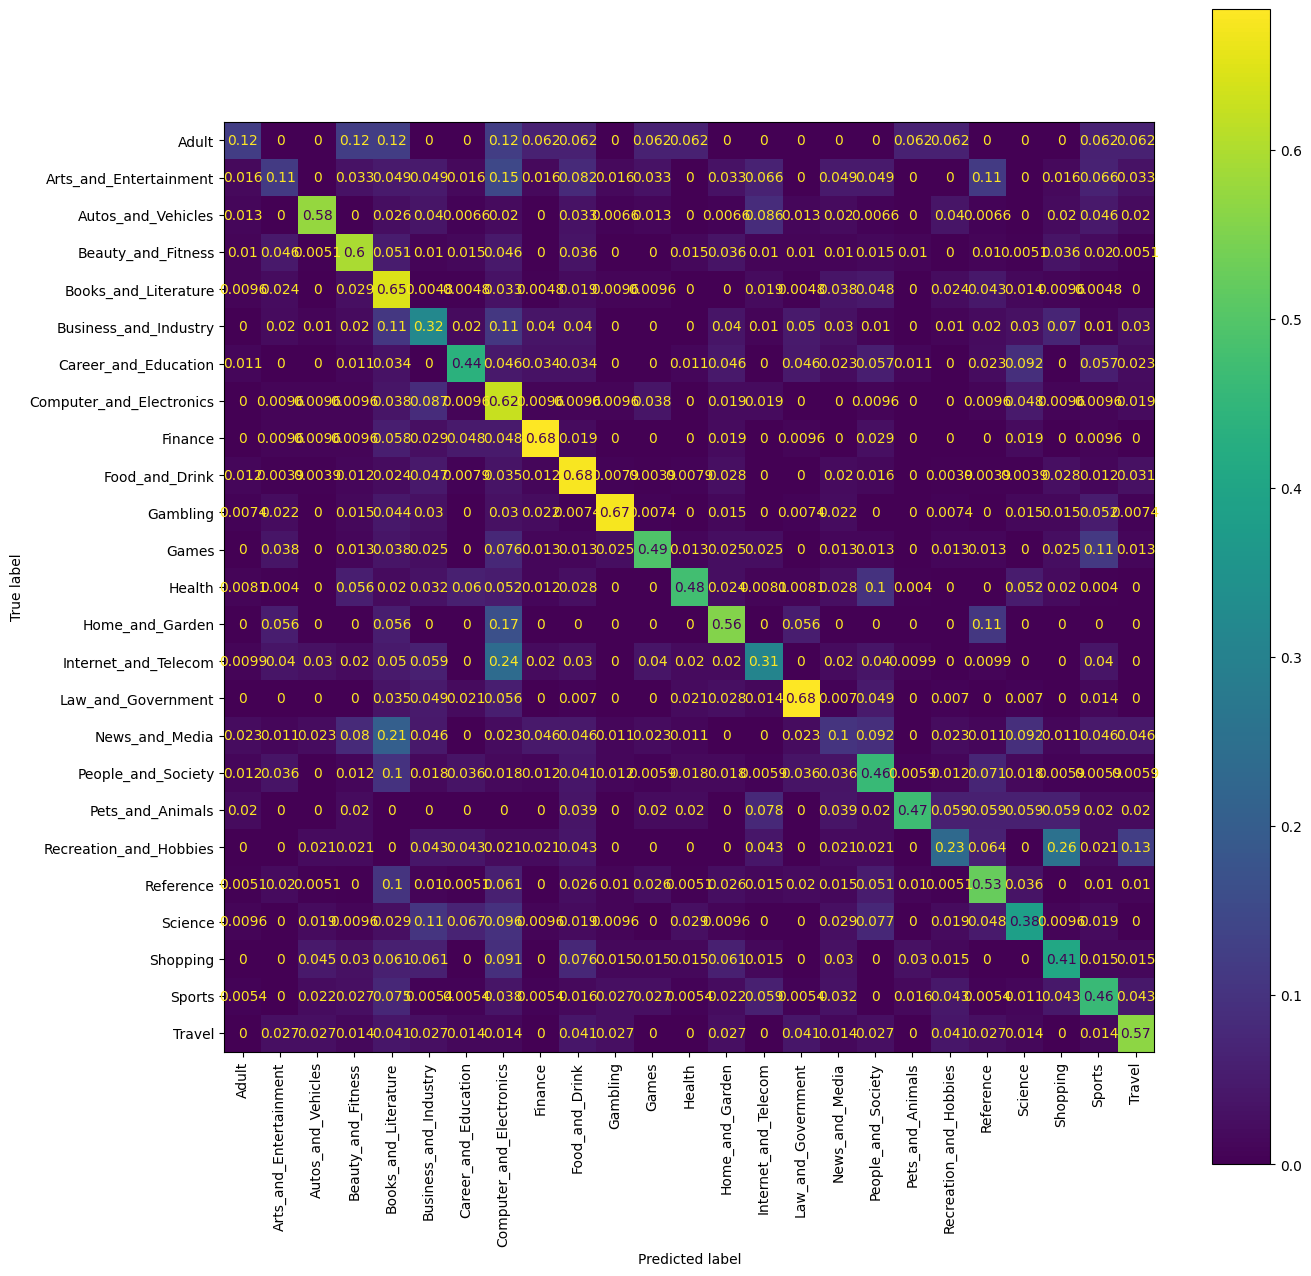

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_custom)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom,xticks_rotation='vertical', normalize = 'true')

fig = cm_display.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

plt.show() 

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred,xticks_rotation='vertical', normalize='true')

fig = cm_display.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

plt.show() 

NameError: name 'y_pred' is not defined

### SVM

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score
classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
classifier.fit(X_train, y_train)

#Predict Class
y_pred_custom = classifier.predict(X_test)

#Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_custom)

/home/ensai/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
accuracy

0.5597989949748744

In [ ]:
f1_score(y_test,y_pred_custom,average='weighted')

0.5609222480537256

### GRID

In [ ]:
df['tokens'] = [' '.join(row['tokens']) for index,row in df.iterrows()]

In [ ]:
df.head()

,url,main_category,main_category_confidence,tld,tokens
0,http://000webhost.com,Internet_and_Telecom,0.5581,com,web hosting host website cpanel php sale cheap...
2,http://0calc.com,Science,0.5606,com,web scientific calculator register login usern...
5,http://100diet.net,Health,0.5991,net,diet diet javascript diet
7,http://1091.co.jp,Sports,0.5912,jp,co iupdate tweet www co qr qr url copyright ic...
8,http://10bet.com,Gambling,0.7795,com,bet bet sport betting welcome bonus open full ...


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_test = train_test_split(df, random_state=42)

In [ ]:
len(df_train)

8953

In [ ]:
len(df_test)

2985

In [1]:
df_train[0]

NameError: name 'df_train' is not defined

In [12]:
from sklearn.pipeline import Pipeline

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [26]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

In [16]:
import numpy as np

In [22]:
text_clf.fit(df_train.tokens, df_train.main_category)

predicted = text_clf.predict(df_test.tokens)

accuracy = np.mean(predicted == df_test.main_category)
print('\nAccuracy of MultinomialNB (naive Bayes) - {}'.format(accuracy * 100))


Accuracy of MultinomialNB (naive Bayes) - 55.30988274706867


In [19]:
predicted

array(['Law_and_Government', 'People_and_Society', 'Food_and_Drink', ...,
       'Sports', 'Reference', 'Health'], dtype='<U24')

In [20]:
df_test.main_category

9218         Law_and_Government
11024        People_and_Society
10427            Food_and_Drink
502                   Reference
5043         Beauty_and_Fitness
                  ...          
14581                   Finance
2276     Arts_and_Entertainment
681                      Sports
11000        People_and_Society
2297      Business_and_Industry
Name: main_category, Length: 2985, dtype: object

In [24]:
from sklearn.model_selection import GridSearchCV

In [27]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_features': (1000, 5000, 20000),
              'tfidf__use_idf': (True, False),
              'clf__fit_prior': (True, False),
              'clf__alpha': (0.5, 1.0)}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf.fit(df_train.tokens, df_train.main_category)


gs_predicted = gs_clf.predict(df_test.tokens)
accuracy = np.mean(gs_predicted == df_test.main_category)
print('\nAccuracy (after tuning) of MultinomialNB (naive Bayes) - {}'.format(accuracy * 100))

KeyboardInterrupt: 

In [101]:
X_train, X_test, y_train, y_test = train_test_split(data_tokens, Y, random_state=42)

In [103]:
from sklearn.pipeline import Pipeline

In [104]:
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [105]:
text_clf = text_clf.fit(X_train, y_train)

/home/ensai/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
y_predict = text_clf.predict(X_test)

In [109]:
import numpy as np

In [111]:
y_predict

array(['Law_and_Government', 'People_and_Society', 'Food_and_Drink', ...,
       'Sports', 'Reference', 'Health'], dtype='<U24')

In [113]:
y_test['main_category']

9218         Law_and_Government
11024        People_and_Society
10427            Food_and_Drink
502                   Reference
5043         Beauty_and_Fitness
                  ...          
14581                   Finance
2276     Arts_and_Entertainment
681                      Sports
11000        People_and_Society
2297      Business_and_Industry
Name: main_category, Length: 2985, dtype: object

In [88]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}

In [90]:
clf = MultinomialNB()

In [91]:
parameters = {'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}  

In [92]:
grid_search= GridSearchCV(clf, parameters)

In [94]:
gs =grid_search.fit(X_train,y_train)

/home/ensai/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ensai/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ensai/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ensai/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

In [95]:
gs.best_params_

{'alpha': 0.1}